In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import statsmodels as sm
import statsmodels.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, ElasticNet
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import r2_score
from scipy import stats
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

In [2]:
smb_2022 = pd.read_excel('SMB_Dataset_2022_Update.xlsx')


In [3]:
print(smb_2022[smb_2022['Significant_Spend'] == 1]['probability_of_lift'].min())
print(smb_2022[smb_2022['Significant_Spend'] == 1]['probability_of_lift'].max())


0.9005
1.0


In [4]:
print(smb_2022[smb_2022['Significant_Spend'] == 0]['probability_of_lift'].min())
print(smb_2022[smb_2022['Significant_Spend'] == 0]['probability_of_lift'].max())


-1.0
0.87109237909317


In [5]:
smb_2022.head()

,study_id,year,quarter,region,country,pa,channel,tactic,conversion,study_name,...,exposed,control_user_count,scaled_control,control,scaling_factor,cost_spent_on_exposed_group,absolute_lift,relative_lift,probability_of_lift,Significant_Spend
0,148603228.0,2021.0,Q1,AMER,AR,SMB,DISPLAY,REMK,Type 288347008 (LENA - B Lead),Google SMB | Q1 2021 | Acquisition | GDN AR RMKT,...,1939.0,2117871.0,2099.850830,899.0,2.335704,15112.32429,-160.850845,-0.076578,0.1321,0.0
1,148603868.0,2021.0,Q1,AMER,AR,SMB,DISPLAY,non-REMK,Type 288347008 (LENA - B Lead),Google SMB | Q1 2021 | Acquisition | GDN AR Pros,...,4045.0,5031838.0,4107.776367,1753.0,2.341607,83446.36284,-62.776375,-0.014577,0.3561,0.0
2,148603229.0,2021.0,Q1,AMER,BR,SMB,DISPLAY,REMK,Type 288347008 (LENA - B Lead),Google SMB | Q1 2021 | Acquisition | GDN BR RMKT,...,22209.0,6513673.0,22519.300781,9658.0,2.327656,86061.69181,-310.300049,-0.012077,0.1686,0.0
3,148603738.0,2021.0,Q1,AMER,BR,SMB,DISPLAY,non-REMK,Type 288347008 (LENA - B Lead),Google SMB | Q1 2021 | Acquisition | GDN BR Pros,...,37402.0,8927700.0,37133.390625,15845.0,2.327620,205559.89220,268.608551,0.014123,0.6315,0.0
4,148603713.0,2021.0,Q1,AMER,CL,SMB,DISPLAY,REMK,Type 288347008 (LENA - B Lead),Google SMB | Q1 2021 | Acquisition | GDN CL RMKT,...,690.0,912420.0,807.356567,347.0,2.329245,12378.59177,-117.356544,-0.146302,0.0744,0.0


In [6]:
#replacing 'NA' values in region with 'EMEA'
smb_2022['region'].fillna('EMEA', inplace = True)

#ensuring there are no null values now
smb_2022.isnull().sum()


study_id                       0
year                           0
quarter                        0
region                         0
country                        0
pa                             0
channel                        0
tactic                         0
conversion                     0
study_name                     0
treatment_user_count           0
exposed                        0
control_user_count             0
scaled_control                 0
control                        0
scaling_factor                 0
cost_spent_on_exposed_group    0
absolute_lift                  0
relative_lift                  0
probability_of_lift            0
Significant_Spend              0
dtype: int64

In [7]:
#seeing which columns can be excluded from classifier 

smb_2022['channel'].value_counts()

DISCOVERY    50
DISPLAY      48
YOUTUBE      14
Name: channel, dtype: int64

Text(0, 0.5, 'Count')

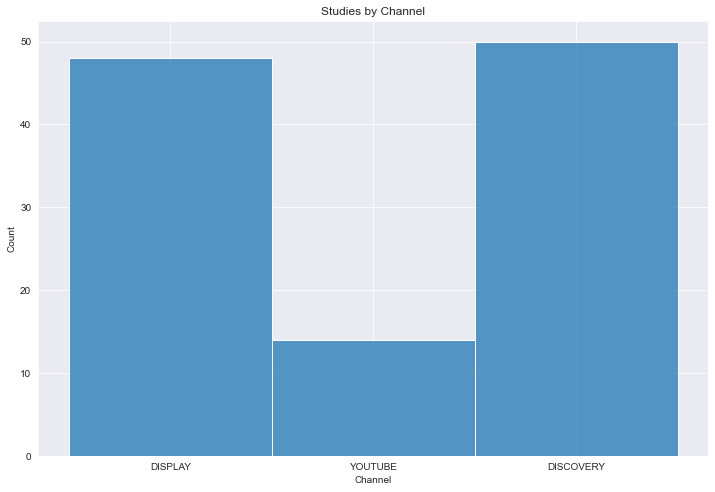

In [8]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.histplot(smb_2022['channel'])
plt.title('Studies by Channel')
plt.xlabel('Channel')
plt.ylabel('Count')

In [9]:
smb_2022['region'].value_counts()

EMEA    77
AMER    24
APAC    11
Name: region, dtype: int64

Text(0, 0.5, 'Count')

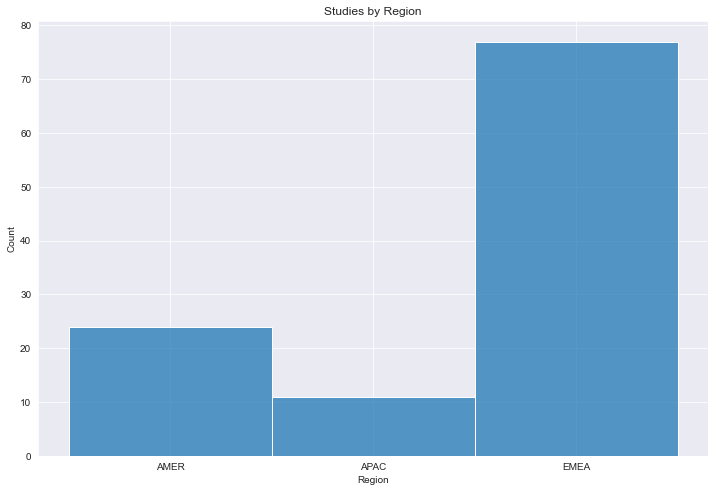

In [10]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.histplot(smb_2022['region'])
plt.title('Studies by Region')
plt.xlabel('Region')
plt.ylabel('Count')

In [11]:
#seeing if there are few countries to encode 
#since there are 38, then country will be excluded from the classifier prediction 
smb_2022['country'].nunique()

38

In [12]:
smb_2022['quarter'].value_counts()

Q2    70
Q1    24
Q4    16
Q3     2
Name: quarter, dtype: int64

Text(0, 0.5, 'Count')

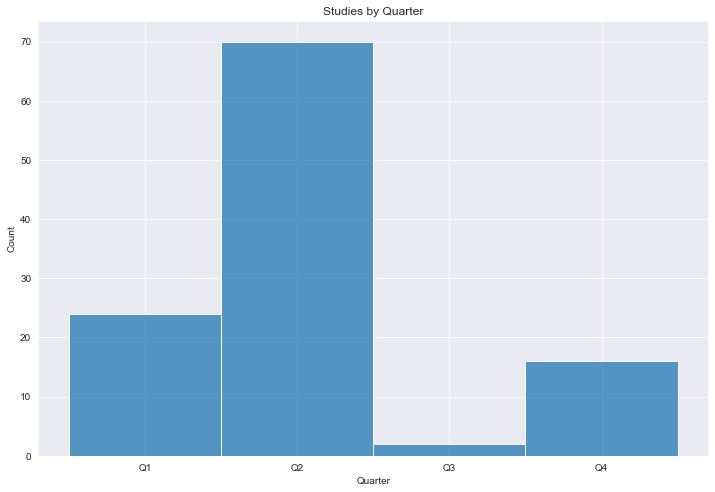

In [13]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.histplot(smb_2022['quarter'])
plt.title('Studies by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count')

In [14]:
smb_2022['tactic'].value_counts()

non-REMK                     48
REMK                         41
All Channel                  17
Mixture (not all channel)     6
Name: tactic, dtype: int64

Text(0, 0.5, 'Count')

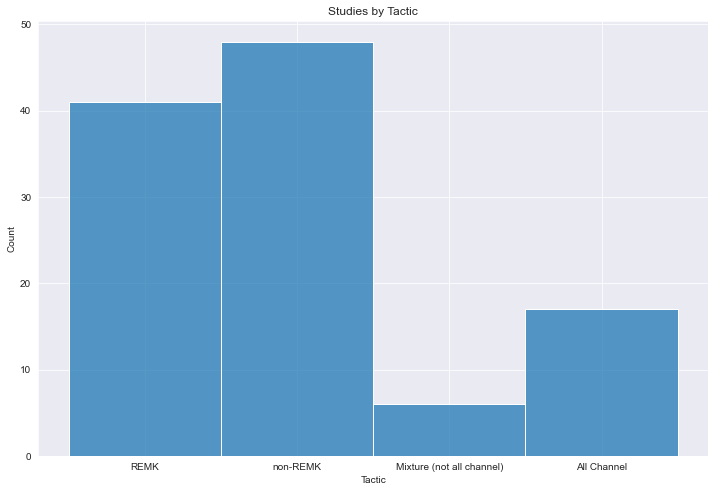

In [15]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.histplot(smb_2022['tactic'])
plt.title('Studies by Tactic')
plt.xlabel('Tactic')
plt.ylabel('Count')

In [16]:
smb_2022['conversion'].value_counts()

Type 288347008 (LENA - B Lead)    90
Type 288697653 (LENA - Q Lead)    18
Type 302982954 (Lena - P Lead)     4
Name: conversion, dtype: int64

Text(0, 0.5, 'Count')

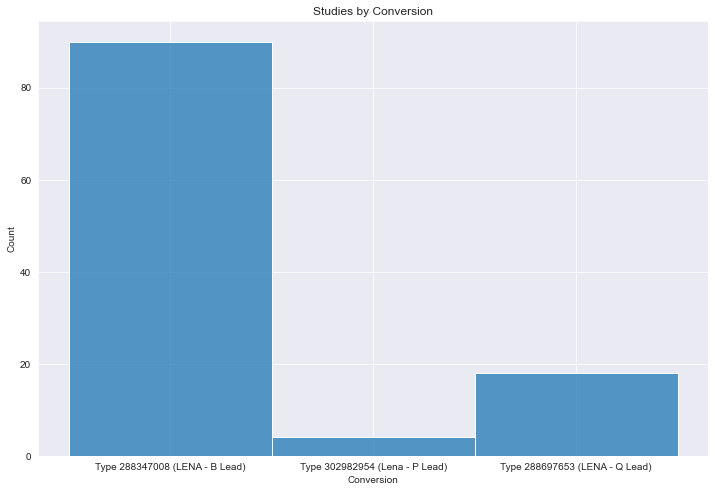

In [17]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.histplot(smb_2022['conversion'])
plt.title('Studies by Conversion')
plt.xlabel('Conversion')
plt.ylabel('Count')

In [18]:
#will be excluded from classifier 
smb_2022['study_name'].nunique()


110

In [19]:
#ensuring all pa's are SMB

smb_2022['pa'].value_counts()

SMB    112
Name: pa, dtype: int64

In [20]:
#making sure variables are float values
smb_2022.dtypes

study_id                       float64
year                           float64
quarter                         object
region                          object
country                         object
pa                              object
channel                         object
tactic                          object
conversion                      object
study_name                      object
treatment_user_count           float64
exposed                        float64
control_user_count             float64
scaled_control                 float64
control                        float64
scaling_factor                 float64
cost_spent_on_exposed_group    float64
absolute_lift                  float64
relative_lift                  float64
probability_of_lift            float64
Significant_Spend              float64
dtype: object

In [21]:
smb_2022.columns

Index(['study_id', 'year', 'quarter', 'region', 'country', 'pa', 'channel',
       'tactic', 'conversion', 'study_name', 'treatment_user_count', 'exposed',
       'control_user_count', 'scaled_control', 'control', 'scaling_factor',
       'cost_spent_on_exposed_group', 'absolute_lift', 'relative_lift',
       'probability_of_lift', 'Significant_Spend'],
      dtype='object')

In [22]:
#excluding columns that won't be used for classifier
smb_2022_classifier = smb_2022.loc[:, ~smb_2022.columns.isin(['study_id', 'year', 'country', 'study_name','pa'])]


In [23]:
smb_2022_classifier.head()

,quarter,region,channel,tactic,conversion,treatment_user_count,exposed,control_user_count,scaled_control,control,scaling_factor,cost_spent_on_exposed_group,absolute_lift,relative_lift,probability_of_lift,Significant_Spend
0,Q1,AMER,DISPLAY,REMK,Type 288347008 (LENA - B Lead),4946720.0,1939.0,2117871.0,2099.850830,899.0,2.335704,15112.32429,-160.850845,-0.076578,0.1321,0.0
1,Q1,AMER,DISPLAY,non-REMK,Type 288347008 (LENA - B Lead),11782586.0,4045.0,5031838.0,4107.776367,1753.0,2.341607,83446.36284,-62.776375,-0.014577,0.3561,0.0
2,Q1,AMER,DISPLAY,REMK,Type 288347008 (LENA - B Lead),15161593.0,22209.0,6513673.0,22519.300781,9658.0,2.327656,86061.69181,-310.300049,-0.012077,0.1686,0.0
3,Q1,AMER,DISPLAY,non-REMK,Type 288347008 (LENA - B Lead),20780289.0,37402.0,8927700.0,37133.390625,15845.0,2.327620,205559.89220,268.608551,0.014123,0.6315,0.0
4,Q1,AMER,DISPLAY,REMK,Type 288347008 (LENA - B Lead),2125250.0,690.0,912420.0,807.356567,347.0,2.329245,12378.59177,-117.356544,-0.146302,0.0744,0.0


In [24]:
#ensuring labels are balanced in dataset 

smb_2022_classifier['Significant_Spend'].value_counts(normalize=True)

0.0    0.5625
1.0    0.4375
Name: Significant_Spend, dtype: float64

In [25]:
#getting dummy values for categorical variables
cols = ['quarter', 'region', 'channel', 'tactic', 'conversion']

encoded_vars = pd.get_dummies(smb_2022_classifier[cols])

smb_2022_classifier = smb_2022_classifier.drop(cols, axis = 1)

smb_classifier = pd.concat([encoded_vars, smb_2022_classifier], axis = 1)

In [26]:
smb_classifier.head()

,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4,region_AMER,region_APAC,region_EMEA,channel_DISCOVERY,channel_DISPLAY,channel_YOUTUBE,...,exposed,control_user_count,scaled_control,control,scaling_factor,cost_spent_on_exposed_group,absolute_lift,relative_lift,probability_of_lift,Significant_Spend
0,1,0,0,0,1,0,0,0,1,0,...,1939.0,2117871.0,2099.850830,899.0,2.335704,15112.32429,-160.850845,-0.076578,0.1321,0.0
1,1,0,0,0,1,0,0,0,1,0,...,4045.0,5031838.0,4107.776367,1753.0,2.341607,83446.36284,-62.776375,-0.014577,0.3561,0.0
2,1,0,0,0,1,0,0,0,1,0,...,22209.0,6513673.0,22519.300781,9658.0,2.327656,86061.69181,-310.300049,-0.012077,0.1686,0.0
3,1,0,0,0,1,0,0,0,1,0,...,37402.0,8927700.0,37133.390625,15845.0,2.327620,205559.89220,268.608551,0.014123,0.6315,0.0
4,1,0,0,0,1,0,0,0,1,0,...,690.0,912420.0,807.356567,347.0,2.329245,12378.59177,-117.356544,-0.146302,0.0744,0.0


In [27]:
#new columns , didn't label encode so as not to treat encoded variables as ranking system 

smb_classifier.columns

Index(['quarter_Q1', 'quarter_Q2', 'quarter_Q3', 'quarter_Q4', 'region_AMER',
       'region_APAC', 'region_EMEA', 'channel_DISCOVERY', 'channel_DISPLAY',
       'channel_YOUTUBE', 'tactic_All Channel',
       'tactic_Mixture (not all channel)', 'tactic_REMK', 'tactic_non-REMK',
       'conversion_Type 288347008 (LENA - B Lead)',
       'conversion_Type 288697653 (LENA - Q Lead)',
       'conversion_Type 302982954 (Lena - P Lead)', 'treatment_user_count',
       'exposed', 'control_user_count', 'scaled_control', 'control',
       'scaling_factor', 'cost_spent_on_exposed_group', 'absolute_lift',
       'relative_lift', 'probability_of_lift', 'Significant_Spend'],
      dtype='object')

In [28]:
smb_classifier.shape

(112, 28)

In [29]:
smb_classifier.describe()

,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4,region_AMER,region_APAC,region_EMEA,channel_DISCOVERY,channel_DISPLAY,channel_YOUTUBE,...,exposed,control_user_count,scaled_control,control,scaling_factor,cost_spent_on_exposed_group,absolute_lift,relative_lift,probability_of_lift,Significant_Spend
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,...,112.000000,1.120000e+02,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,0.214286,0.625000,0.017857,0.142857,0.214286,0.098214,0.687500,0.446429,0.428571,0.125000,...,15935.366071,5.845170e+06,14191.012994,6104.276786,2.326244,63126.888650,1742.712540,0.106015,0.674219,0.437500
std,0.412170,0.486299,0.133027,0.351500,0.412170,0.298942,0.465596,0.499356,0.497096,0.332205,...,71919.224703,2.873560e+07,66467.927258,28506.288041,0.027690,92015.375541,6489.632034,0.273963,0.357756,0.498308
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,2.961000e+03,-1.000000,-1.000000,2.223291,173.221786,-537.000000,-1.000000,-1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1204.000000,3.177130e+05,1125.793427,482.000000,2.318871,12615.286332,-19.588611,-0.014802,0.428125,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,3768.000000,1.511968e+06,3777.800537,1625.500000,2.328877,33094.087802,144.500000,0.048457,0.793350,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,11550.750000,4.712322e+06,11024.165283,4722.250000,2.335021,78452.303312,589.805069,0.135395,0.990074,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,758504.000000,3.027281e+08,703406.583500,301637.000000,2.511795,629561.703100,54913.676296,1.491129,1.000000,1.000000


# Outlier detection technique with IsolationForest

In [30]:
#need to implement this on original smb data before dummies and scaling transformation

smb_classifier.columns

Index(['quarter_Q1', 'quarter_Q2', 'quarter_Q3', 'quarter_Q4', 'region_AMER',
       'region_APAC', 'region_EMEA', 'channel_DISCOVERY', 'channel_DISPLAY',
       'channel_YOUTUBE', 'tactic_All Channel',
       'tactic_Mixture (not all channel)', 'tactic_REMK', 'tactic_non-REMK',
       'conversion_Type 288347008 (LENA - B Lead)',
       'conversion_Type 288697653 (LENA - Q Lead)',
       'conversion_Type 302982954 (Lena - P Lead)', 'treatment_user_count',
       'exposed', 'control_user_count', 'scaled_control', 'control',
       'scaling_factor', 'cost_spent_on_exposed_group', 'absolute_lift',
       'relative_lift', 'probability_of_lift', 'Significant_Spend'],
      dtype='object')

In [31]:
labels = smb_classifier.columns.drop(['Significant_Spend'])
target = smb_classifier['Significant_Spend']

isf = IsolationForest(n_jobs=-1, random_state=1)
isf.fit(smb_classifier[labels], target)


print(isf.score_samples(smb_classifier[labels]))

[-0.4515144  -0.45107908 -0.52172982 -0.55195437 -0.46108157 -0.42651765
 -0.4260127  -0.43565177 -0.43532132 -0.44378634 -0.44611131 -0.44803507
 -0.4204084  -0.44752087 -0.80166674 -0.49816568 -0.49597043 -0.49307798
 -0.49798328 -0.61876283 -0.66478874 -0.45215244 -0.44809237 -0.46365703
 -0.46563356 -0.45025282 -0.45937924 -0.45024135 -0.44000259 -0.43975628
 -0.45803569 -0.61458444 -0.61924976 -0.59226464 -0.56990806 -0.55526667
 -0.54151523 -0.42706379 -0.47126707 -0.60156476 -0.42413348 -0.43267934
 -0.43009043 -0.49173885 -0.4371855  -0.43408955 -0.46740772 -0.58558572
 -0.49924451 -0.49640477 -0.47986114 -0.51360554 -0.38126859 -0.45228059
 -0.38454734 -0.48671313 -0.39905315 -0.398161   -0.45885407 -0.45150008
 -0.39657056 -0.38396871 -0.46474717 -0.37953897 -0.38370904 -0.38375179
 -0.38895586 -0.47058471 -0.39356184 -0.37325515 -0.3684544  -0.37786994
 -0.3887708  -0.39281267 -0.38232421 -0.39198034 -0.54723734 -0.51116435
 -0.39031106 -0.38338042 -0.4090981  -0.3750164  -0

In [32]:
#predicting what data points are outliers (1 is not an outlier, -1 is an outlier)

outlier_predictions = isf.predict(smb_classifier[labels])
outlier_predictions

array([ 1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,
       -1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [33]:
#total of 17 outliers 

list(outlier_predictions).count(-1)

17

In [34]:
#getting index values so we can find which points are outliers 

indices = []
for index, elem in enumerate(list(outlier_predictions)):
        if elem == -1:
            indices.append(index)
            

In [35]:
indices

[2, 3, 14, 19, 20, 31, 32, 33, 34, 35, 36, 39, 47, 51, 76, 77, 90]

In [36]:
#extracting outlier data points
outliers = smb_classifier.loc[indices, :]

In [37]:
outliers.head()

,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4,region_AMER,region_APAC,region_EMEA,channel_DISCOVERY,channel_DISPLAY,channel_YOUTUBE,...,exposed,control_user_count,scaled_control,control,scaling_factor,cost_spent_on_exposed_group,absolute_lift,relative_lift,probability_of_lift,Significant_Spend
2,1,0,0,0,1,0,0,0,1,0,...,22209.0,6513673.0,22519.300781,9658.0,2.327656,86061.69181,-310.300049,-0.012077,0.1686,0.0
3,1,0,0,0,1,0,0,0,1,0,...,37402.0,8927700.0,37133.390625,15845.0,2.327620,205559.89220,268.608551,0.014123,0.6315,0.0
14,0,1,0,0,0,1,0,0,0,1,...,758504.0,302728054.0,703406.583500,301637.0,2.331964,451908.10610,54913.676296,0.078329,1.0000,1.0
19,0,0,1,0,0,1,0,1,0,0,...,35455.0,7869321.0,24209.000000,10348.0,2.339398,162129.74590,11246.000000,0.464593,1.0000,1.0
20,0,0,1,0,0,1,0,1,0,0,...,77093.0,17988278.0,50421.000000,21560.0,2.337495,157713.91460,26672.000000,0.529733,1.0000,1.0


In [38]:
no_outliers = smb_classifier.drop(smb_classifier.iloc[indices].index)
len(no_outliers)

95

Text(0.5, 1.0, 'Cost Spent vs. Absolute Lift (Non-outliers vs. Outliers)')

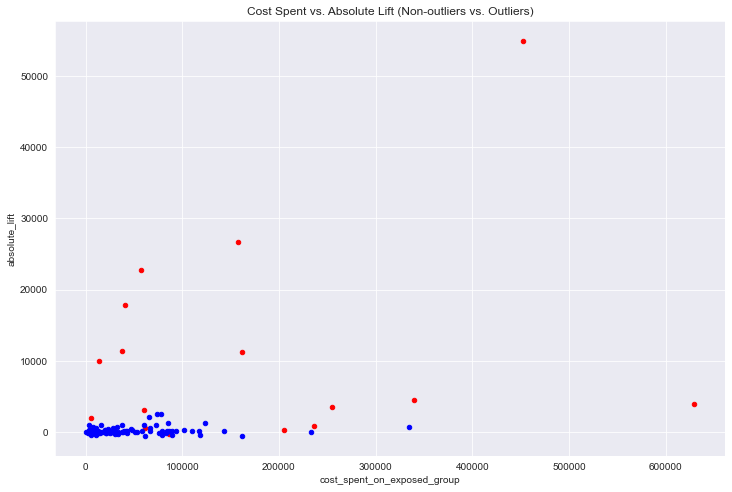

In [39]:
#plotting outliers vs non outliers on cost spent to see if they visually look like outliers 
# open figure/axis
fig, ax = plt.subplots(figsize=(12,8))

# plot // you need to specify the axis
outliers.plot(x='cost_spent_on_exposed_group', y='absolute_lift', kind='scatter', ax=ax, c='r')
no_outliers.plot(x='cost_spent_on_exposed_group', y='absolute_lift', kind='scatter', ax=ax, c='b')
plt.title('Cost Spent vs. Absolute Lift (Non-outliers vs. Outliers)')

In [40]:
#copying ridge regression function form EDA notebook and running it on non outliers to see if rmse scores improve 

def ridge_regression_2(dataset, powers, channel):

    rmse_scores = {}
    r2_scores = {}
    fig_count = 1
    
    for i in powers:
        
        x = dataset[dataset['channel_' + channel ] == 1]['cost_spent_on_exposed_group']
        y = dataset[dataset['channel_' + channel] == 1]['absolute_lift']
    
        #need to reshape x and y
        x = np.array(x).reshape(-1,1)
        y = np.array(y).reshape(-1,1)
    
        
        #initializing model
        ridge = Ridge(alpha = 0.1)
        ridge.fit(x**i,y)
        pred_train_ridge = ridge.predict(x**i)
        rmse_scores[i] = np.sqrt(mean_squared_error(y, pred_train_ridge))
        r2_scores[i] = r2_score(y, pred_train_ridge)
        
        #sorting x and y values for line plot 
        #x_plot, y_plot = zip(*sorted(zip(x, pred_train_ridge)))
        
        #code to smoothen line 
        #xnew = np.linspace(np.asarray(x_plot).min(), np.asarray(x_plot).max(), 200) 
        
        #define spline
        #spl = make_interp_spline(np.asarray(x_plot).flatten(), np.asarray(y_plot).flatten(), k=2)
        #y_smooth = spl(xnew)

        #plotting fitted values against real values
        #fig = plt.figure(figsize = (12,8))
        #plt.scatter(x,y)
        #plt.plot(xnew,y_smooth, c = 'r')
        #plt.title(channel + ' channel: Ridge Regression Modeling', fontsize=16)
        #plt.xlabel('Cost Spent on Exposed Group ^ ' + str(i))
        #plt.ylabel('Absolute Lift')
        #plt.savefig('Modeling Results WO Outliers/{} Ridge {}.png'.format(channel,fig_count))
        #plt.close(fig)
        #fig_count += 1
        
        
    return min(rmse_scores.items(), key=lambda x: x[1]), max(r2_scores.items(), key=lambda x: x[1])


In [41]:
powers = []
for i in np.arange(0.1,0.9,0.01):
    powers.append(i)

In [42]:
ridge_regression_2(no_outliers, powers = powers, channel = 'DISPLAY')

((0.8899999999999996, 170.6225972346506),
 (0.8899999999999996, 0.26615566260898016))

In [43]:
#this outlier exclusion did not improve RMSE scores for discovery 
ridge_regression_2(no_outliers, powers = powers, channel = 'DISCOVERY')

((0.1, 698.0272920696762), (0.1, 0.027190063352883542))

In [44]:
ridge_regression_2(no_outliers, powers = powers, channel = 'YOUTUBE')

((0.8899999999999996, 492.77361009751303),
 (0.8899999999999996, 0.2000122528463747))

# Splitting training and testing & Scaling data 

In [45]:
#splitting into training and testing 

x = smb_classifier.iloc[:,:-1]
y = smb_classifier.iloc[:,-1]


x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2)

#grabbing variables that weren't transformed using dummy values to scale 
cols = ['treatment_user_count', 'exposed', 'control_user_count', 'scaled_control', 'control',
        'scaling_factor', 'cost_spent_on_exposed_group', 'absolute_lift', 'relative_lift', 'probability_of_lift']

#initializing scaler - robust scaler will be more robust to outliers 
rs = RobustScaler()

num_cols = x_train[cols]
x_train_scaled = rs.fit_transform(num_cols.values)
x_train[cols] = x_train_scaled

#transforming x test with same scaler 
num_cols_2 = x_test[cols]
x_test_scaled = rs.fit_transform(num_cols_2.values)
x_test[cols] = x_test_scaled

In [46]:
len(x_train)

89

In [47]:
len(x_test)

23

In [48]:
x_train.head()

,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4,region_AMER,region_APAC,region_EMEA,channel_DISCOVERY,channel_DISPLAY,channel_YOUTUBE,...,treatment_user_count,exposed,control_user_count,scaled_control,control,scaling_factor,cost_spent_on_exposed_group,absolute_lift,relative_lift,probability_of_lift
63,0,1,0,0,0,0,1,1,0,0,...,0.137917,-0.003874,0.138372,0.042417,0.045066,-0.474656,-0.265761,-0.628782,-0.571296,-0.994178
55,0,1,0,0,0,0,1,1,0,0,...,0.710194,0.573448,0.710510,0.684388,0.685833,-0.519952,0.754540,-1.071877,-0.551721,-1.032665
23,0,0,0,1,1,0,0,0,1,0,...,-0.198534,-0.350330,-0.198286,-0.333303,-0.329966,0.009091,-0.236111,-0.544740,-1.798752,-1.127728
49,0,1,0,0,0,1,0,1,0,0,...,1.765861,-0.005549,1.771131,-0.052067,-0.047397,-0.884342,-0.329054,1.139317,1.158905,0.360582
21,0,0,0,1,1,0,0,0,1,0,...,-0.010897,-0.295257,-0.011713,-0.301451,-0.298109,0.121548,0.000000,-0.026402,0.744159,0.312075


In [49]:
x_test.head()


,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4,region_AMER,region_APAC,region_EMEA,channel_DISCOVERY,channel_DISPLAY,channel_YOUTUBE,...,treatment_user_count,exposed,control_user_count,scaled_control,control,scaling_factor,cost_spent_on_exposed_group,absolute_lift,relative_lift,probability_of_lift
108,0,1,0,0,0,0,1,0,0,1,...,-0.451529,0.132551,-0.449749,0.123533,0.135733,-4.504900,-0.546611,-0.144557,-0.299935,-0.602043
31,0,0,0,1,0,1,0,0,0,1,...,1.024123,0.365973,1.044002,0.069368,0.077340,-3.058797,11.859173,5.356725,3.828731,0.200789
9,1,0,0,0,1,0,0,0,1,0,...,0.746788,-0.111929,0.747002,-0.116242,-0.114374,-0.075619,0.263690,-0.189642,-0.280907,-0.644428
110,0,1,0,0,0,0,1,0,1,0,...,-0.457700,-0.386222,-0.456082,-0.381897,-0.380157,-0.947396,-0.548605,-0.304989,-1.460943,-1.451610
16,0,1,0,0,0,0,1,0,1,0,...,-0.183508,-0.202115,-0.182138,-0.215390,-0.213418,-0.140697,-0.158258,0.000000,0.148584,-0.008413


# Logistic Regression

In [50]:
lr_accuracy_best_params = []
lr_roc_auc_best_params = []
lr_f1_best_params = []
    
log_reg = LogisticRegression(max_iter=10000)
    
#parameters to be tested in grid search
grid_params = [{'solver':['saga'],
               'penalty': ['l1','l2'],
               'C':[.0001, .001, .01, .1, 1, 10, 100, 1000, 10000]},
              {'solver':['lbfgs'],
              'penalty':['12'],
              'C': [.0001, .001, .01, .1, 1, 10, 100, 1000, 10000],
              'solver':['lbfgs','saga'],
              'penalty':['none']}]
#gridsearch    
clf = GridSearchCV(estimator = log_reg, param_grid = grid_params, cv = StratifiedKFold(n_splits=5), 
                    scoring = ['accuracy', 'roc_auc_ovr', 'f1_micro'], refit = False, verbose = 0)
    
    
#fitting model 
model = clf.fit(x_train, y_train)
    
lr_accuracy_best_params.append(model.cv_results_['params'][np.argmin(model.cv_results_['rank_test_accuracy'])])
lr_roc_auc_best_params.append(model.cv_results_['params'][np.argmin(model.cv_results_['rank_test_roc_auc_ovr'])])
lr_f1_best_params.append(model.cv_results_['params'][np.argmin(model.cv_results_['rank_test_f1_micro'])])
    
    

C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_mode

C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\alexa.hurtado\Anaconda3\lib\site-packages\sklearn\linear_mode

## Accuracy Scores

In [51]:
lr_accuracy_best_params

[{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}]

In [52]:
lr_accuracy_test_errors = []
lr_accuracy_train_errors = []

for param in lr_accuracy_best_params:
    
    n = 0
    if 'C' in param:
        
        logreg_clf = LogisticRegression(penalty = param['penalty'], solver = param['solver'], C = param['C'], max_iter = 10000)
        model = logreg_clf.fit(x_train, y_train)
    else:
        
        logreg_clf = LogisticRegression(penalty = param['penalty'], solver = param['solver'], max_iter = 10000)
        model = logreg_clf.fit(x_train, y_train)
        
    y_pred = model.predict(x_test)
    lr_accuracy_test_errors.append(accuracy_score(y_test, y_pred))
    
    y_pred_train = model.predict(x_train)
    lr_accuracy_train_errors.append(accuracy_score(y_train, y_pred_train))

In [53]:
print('test accuracy scores {}:'.format(lr_accuracy_test_errors))
print('train accuracy scores {}:'.format(lr_accuracy_train_errors))

test accuracy scores [0.782608695652174]:
train accuracy scores [0.9550561797752809]:


## ROC AUC Scores

In [54]:
lr_roc_auc_best_params

[{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}]

In [55]:
lr_roc_test_errors = []
lr_roc_train_errors = []

for param in lr_roc_auc_best_params:
    
    n = 0
    if 'C' in param:
        
        logreg_clf = LogisticRegression(penalty = param['penalty'], solver = param['solver'], C = param['C'], max_iter = 10000)
        model = logreg_clf.fit(x_train, y_train)
    else:
        
        logreg_clf = LogisticRegression(penalty = param['penalty'], solver = param['solver'], max_iter = 10000)
        model = logreg_clf.fit(x_train, y_train)
        
    y_pred = model.predict(x_test)
    lr_roc_test_errors.append(roc_auc_score(y_test, y_pred))
    
    y_pred_train = model.predict(x_train)
    lr_roc_train_errors.append(roc_auc_score(y_train, y_pred_train))

In [56]:
print('test roc auc scores {}:'.format(lr_roc_test_errors))
print('train roc auc scores {}:'.format(lr_roc_train_errors))

test roc auc scores [0.8076923076923077]:
train roc auc scores [0.8888888888888888]:


## F1 Scores

In [57]:
lr_f1_best_params

[{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}]

In [58]:
lr_f1_test_errors = []
lr_f1_train_errors = []

for param in lr_f1_best_params:
    
    n = 0
    if 'C' in param:
        
        logreg_clf = LogisticRegression(penalty = param['penalty'], solver = param['solver'], C = param['C'], max_iter = 10000)
        model = logreg_clf.fit(x_train, y_train)
    else:
        
        logreg_clf = LogisticRegression(penalty = param['penalty'], solver = param['solver'], max_iter = 10000)
        model = logreg_clf.fit(x_train, y_train)
        
    y_pred = model.predict(x_test)
    lr_f1_test_errors.append(f1_score(y_test, y_pred))
    
    y_pred_train = model.predict(x_train)
    lr_f1_train_errors.append(f1_score(y_train, y_pred_train))

In [59]:
print('test f1 scores {}:'.format(lr_f1_test_errors))
print('train f1 scores {}:'.format(lr_f1_train_errors))

test f1 scores [0.761904761904762]:
train f1 scores [0.9411764705882353]:


# SVM 

In [60]:
svm_accuracy_best_params = []
svm_roc_auc_best_params = []
svm_f1_best_params = []


svm = SVC(max_iter=10000)
        
#parameters to be tested in grid search
grid_params = {'kernel':['linear', 'poly', 'rbf'],'C':[.0001, .001, .01, .1, 1, 10, 100, 1000, 10000], 
               'gamma': [ 0.0001,.001,.01,.1,1,10,100,1000,10000], 'probability':[True]}

clf = GridSearchCV(estimator = svm, param_grid = grid_params, cv = StratifiedKFold(n_splits=5), 
                    scoring = ['accuracy', 'roc_auc_ovr', 'f1_micro'], refit = False, verbose = 0)
    
    
#need to fit model on svm
model = clf.fit(x_train, y_train)
    
svm_accuracy_best_params.append(model.cv_results_['params'][np.argmin(model.cv_results_['rank_test_accuracy'])])
svm_roc_auc_best_params.append(model.cv_results_['params'][np.argmin(model.cv_results_['rank_test_roc_auc_ovr'])])
svm_f1_best_params.append(model.cv_results_['params'][np.argmin(model.cv_results_['rank_test_f1_micro'])])    


## Accuracy Scores

In [61]:
svm_accuracy_best_params

[{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}]

In [62]:
svm_accuracy_test_errors = []
svm_accuracy_train_errors = []

for param in svm_accuracy_best_params:
    
    
        
    svm_clf = SVC(kernel = param['kernel'], C = param['C'], gamma = param['gamma'], max_iter = 10000)
    model = svm_clf.fit(x_train, y_train)
   
        
    y_pred = model.predict(x_test)
    svm_accuracy_test_errors.append(accuracy_score(y_test, y_pred))
    
    y_pred_train = model.predict(x_train)
    svm_accuracy_train_errors.append(accuracy_score(y_train, y_pred_train))

In [63]:
print('test accuracy scores {}:'.format(svm_accuracy_test_errors))
print('train accuracy scores {}:'.format(svm_accuracy_train_errors))

test accuracy scores [0.8695652173913043]:
train accuracy scores [1.0]:


## ROC AUC Scores

In [64]:
svm_roc_auc_best_params

[{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear', 'probability': True}]

In [65]:
svm_roc_test_errors = []
svm_roc_train_errors = []

for param in svm_roc_auc_best_params:
    
    
        
    svm_clf = SVC(kernel = param['kernel'], C = param['C'], gamma = param['gamma'], max_iter = 10000)
    model = svm_clf.fit(x_train, y_train)
   
        
    y_pred = model.predict(x_test)
    svm_roc_test_errors.append(roc_auc_score(y_test, y_pred))
    
    y_pred_train = model.predict(x_train)
    svm_roc_train_errors.append(roc_auc_score(y_train, y_pred_train))

In [66]:
print('test roc auc scores {}:'.format(svm_roc_test_errors))
print('train roc auc scores {}:'.format(svm_roc_train_errors))

test roc auc scores [0.6923076923076923]:
train roc auc scores [0.7361111111111112]:


## F1 Scores

In [67]:
svm_f1_best_params

[{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}]

In [68]:
svm_f1_test_errors = []
svm_f1_train_errors = []

for param in svm_f1_best_params:
    
    
        
    svm_clf = SVC(kernel = param['kernel'], C = param['C'], gamma = param['gamma'], max_iter = 10000)
    model = svm_clf.fit(x_train, y_train)
   
        
    y_pred = model.predict(x_test)
    svm_f1_test_errors.append(f1_score(y_test, y_pred))
    
    y_pred_train = model.predict(x_train)
    svm_f1_train_errors.append(f1_score(y_train, y_pred_train))

In [69]:
print('test f1 scores {}:'.format(svm_f1_test_errors))
print('train f1 scores {}:'.format(svm_f1_train_errors))

test f1 scores [0.8799999999999999]:
train f1 scores [1.0]:


# Naive Bayes

In [70]:
nb_accuracy_best_params = []
nb_roc_auc_best_params = []
nb_f1_best_params = []
    
nb = BernoulliNB()

#parameters to be tested in grid search
grid_params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}

clf = GridSearchCV(estimator = nb, param_grid = grid_params, cv = StratifiedKFold(n_splits=5), 
                    scoring = ['accuracy', 'roc_auc_ovr', 'f1_micro'], refit = False, verbose = 0)
    

#need to fit model on naive bayes 
model = clf.fit(x_train, y_train)   


nb_accuracy_best_params.append(model.cv_results_['params'][np.argmin(model.cv_results_['rank_test_accuracy'])])
nb_roc_auc_best_params.append(model.cv_results_['params'][np.argmin(model.cv_results_['rank_test_roc_auc_ovr'])])
nb_f1_best_params.append(model.cv_results_['params'][np.argmin(model.cv_results_['rank_test_f1_micro'])])    

## Accuracy Scores

In [71]:
nb_accuracy_best_params

[{'alpha': 0.01}]

In [72]:
nb_accuracy_test_errors = []
nb_accuracy_train_errors = []

for param in nb_accuracy_best_params:
    
    
        
    nb_clf = BernoulliNB(alpha = param['alpha'])
    model = nb_clf.fit(x_train, y_train)
   
        
    y_pred = model.predict(x_test)
    nb_accuracy_test_errors.append(accuracy_score(y_test, y_pred))
    
    y_pred_train = model.predict(x_train)
    nb_accuracy_train_errors.append(accuracy_score(y_train, y_pred_train))

In [73]:
print('test accuracy scores {}:'.format(nb_accuracy_test_errors))
print('train accuracy scores {}:'.format(nb_accuracy_train_errors))

test accuracy scores [0.8260869565217391]:
train accuracy scores [0.898876404494382]:


## ROC AUC Scores

In [74]:
nb_roc_auc_best_params

[{'alpha': 0.01}]

In [75]:
nb_roc_auc_test_errors = []
nb_roc_auc_train_errors = []

for param in nb_roc_auc_best_params:
    
    
        
    nb_clf = BernoulliNB(alpha = param['alpha'])
    model = nb_clf.fit(x_train, y_train)
   
        
    y_pred = model.predict(x_test)
    nb_roc_auc_test_errors.append(roc_auc_score(y_test, y_pred))
    
    y_pred_train = model.predict(x_train)
    nb_roc_auc_train_errors.append(roc_auc_score(y_train, y_pred_train))

In [76]:
print('test roc auc scores {}:'.format(nb_roc_auc_test_errors))
print('train roc auc scores {}:'.format(nb_roc_auc_train_errors))

test roc auc scores [0.8461538461538461]:
train roc auc scores [0.8883647798742139]:


## F1 Scores

In [77]:
nb_f1_best_params

[{'alpha': 0.01}]

In [78]:
nb_f1_test_errors = []
nb_f1_train_errors = []

for param in nb_f1_best_params:
    
    
        
    nb_clf = BernoulliNB(alpha = param['alpha'])
    model = nb_clf.fit(x_train, y_train)
   
        
    y_pred = model.predict(x_test)
    nb_f1_test_errors.append(f1_score(y_test, y_pred))
    
    y_pred_train = model.predict(x_train)
    nb_f1_train_errors.append(f1_score(y_train, y_pred_train))

In [79]:
print('test f1 scores {}:'.format(nb_f1_test_errors))
print('train f1 scores {}:'.format(nb_f1_train_errors))

test f1 scores [0.8181818181818181]:
train f1 scores [0.8695652173913043]:


# Multiple Linear Regression model for predicting probability in lift / absolute lift

In [80]:
#factors to consider: channel, region, quarter, tactic, conversion, treatment user count, exposed, control user count,
#scaled control, control, scaling factor, cost spent on exposed group 

In [81]:
smb_classifier.columns

Index(['quarter_Q1', 'quarter_Q2', 'quarter_Q3', 'quarter_Q4', 'region_AMER',
       'region_APAC', 'region_EMEA', 'channel_DISCOVERY', 'channel_DISPLAY',
       'channel_YOUTUBE', 'tactic_All Channel',
       'tactic_Mixture (not all channel)', 'tactic_REMK', 'tactic_non-REMK',
       'conversion_Type 288347008 (LENA - B Lead)',
       'conversion_Type 288697653 (LENA - Q Lead)',
       'conversion_Type 302982954 (Lena - P Lead)', 'treatment_user_count',
       'exposed', 'control_user_count', 'scaled_control', 'control',
       'scaling_factor', 'cost_spent_on_exposed_group', 'absolute_lift',
       'relative_lift', 'probability_of_lift', 'Significant_Spend'],
      dtype='object')

In [82]:
corrMatrix = smb_classifier.corr()
corrMatrix

,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4,region_AMER,region_APAC,region_EMEA,channel_DISCOVERY,channel_DISPLAY,channel_YOUTUBE,...,exposed,control_user_count,scaled_control,control,scaling_factor,cost_spent_on_exposed_group,absolute_lift,relative_lift,probability_of_lift,Significant_Spend
quarter_Q1,1.000000e+00,-0.674200,-0.070418,-0.213201,0.469697,-0.172345,-0.305144,-0.468979,0.471111,-6.391640e-17,...,-0.067763,-0.061428,-0.064438,-0.064358,-0.047314,-0.031327,-0.090841,-0.012513,-0.021824,-0.065795
quarter_Q2,-6.741999e-01,1.000000,-0.174078,-0.527046,-0.674200,-0.054224,0.631653,0.547212,-0.521749,-4.182429e-02,...,0.075832,0.075752,0.084525,0.084660,0.051174,-0.111056,-0.025533,-0.143696,-0.073384,-0.023236
quarter_Q3,-7.041788e-02,-0.174078,1.000000,-0.055048,-0.070418,0.408586,-0.200000,0.150151,-0.116775,-5.096472e-02,...,0.075970,0.033389,0.047121,0.046800,0.059687,0.142481,0.359323,0.193382,0.123341,0.152894
quarter_Q4,-2.132007e-01,-0.527046,-0.055048,1.000000,0.408635,0.122481,-0.440386,-0.263965,0.213605,7.715167e-02,...,-0.054206,-0.045407,-0.059213,-0.059372,-0.037907,0.136458,0.005858,0.140289,0.080439,0.051434
region_AMER,4.696970e-01,-0.674200,-0.070418,0.408635,1.000000,-0.172345,-0.774597,-0.468979,0.603023,-1.973855e-01,...,-0.083933,-0.061437,-0.077305,-0.077752,0.096877,-0.121139,-0.138256,-0.159105,-0.190562,-0.285112
region_APAC,-1.723455e-01,-0.054224,0.408586,0.122481,-0.172345,1.000000,-0.489494,0.065739,-0.225178,2.381295e-01,...,0.331010,0.354494,0.317960,0.317719,0.149343,0.566958,0.410940,0.241926,0.269829,0.313726
region_EMEA,-3.051441e-01,0.631653,-0.200000,-0.440386,-0.774597,-0.489494,1.000000,0.372957,-0.389249,2.184202e-02,...,-0.138227,-0.173220,-0.135716,-0.135166,-0.181648,-0.256784,-0.141458,-0.014484,-0.004552,0.050965
channel_DISCOVERY,-4.689790e-01,0.547212,0.150151,-0.263965,-0.468979,0.065739,0.372957,1.000000,-0.777714,-3.394221e-01,...,-0.025464,-0.040830,-0.033439,-0.033638,0.051492,-0.000584,0.060516,0.006296,0.035124,0.004526
channel_DISPLAY,4.711115e-01,-0.521749,-0.116775,0.213605,0.603023,-0.225178,-0.389249,-0.777714,1.000000,-3.273268e-01,...,-0.152932,-0.125088,-0.143742,-0.144493,0.318078,-0.210656,-0.222368,-0.079448,-0.162647,-0.145479
channel_YOUTUBE,-6.391640e-17,-0.041824,-0.050965,0.077152,-0.197386,0.238130,0.021842,-0.339422,-0.327327,1.000000e+00,...,0.267116,0.248549,0.265352,0.266776,-0.553357,0.316092,0.241775,0.109418,0.190580,0.210884


<AxesSubplot:>

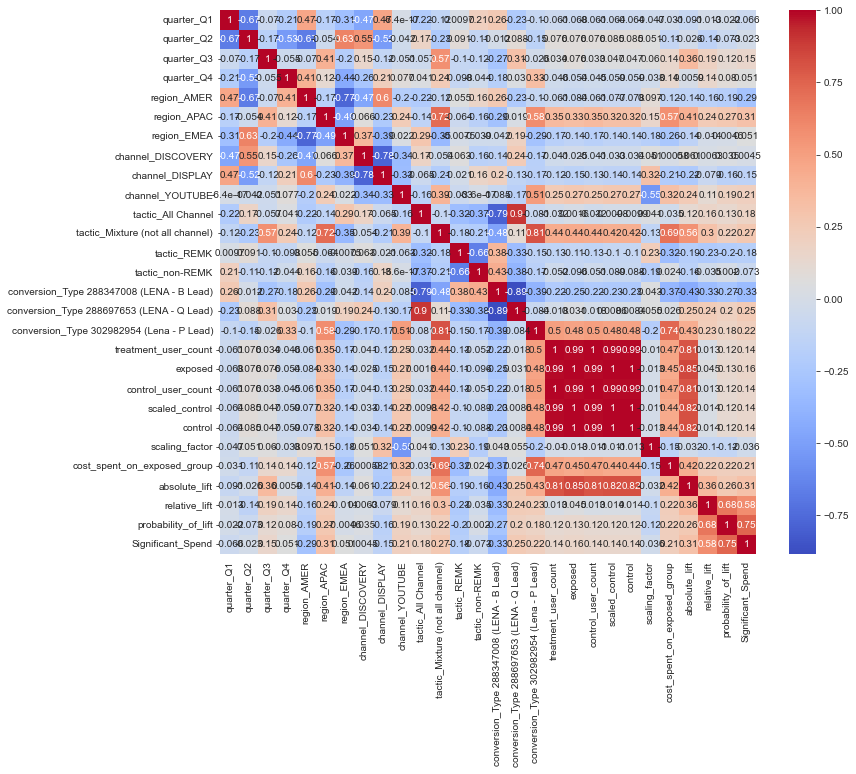

In [83]:
plt.figure(figsize=[12,10])
sns.heatmap(corrMatrix, annot = True, cmap= 'coolwarm')

In [84]:
#seeing what would make a study 'highly effective' = highly effective to be defined as a high probability of lift. 
#what leads to a high probability in lift? 

smb_classifier[smb_classifier['Significant_Spend'] == 1]['probability_of_lift']
print(smb_classifier[smb_classifier['Significant_Spend'] == 1]['probability_of_lift'].min())
print(smb_classifier[smb_classifier['Significant_Spend'] == 1]['probability_of_lift'].max())


0.9005
1.0


In [85]:
# we can see how the ranges differ for probability of lift for sig studies 

smb_classifier[smb_classifier['Significant_Spend'] == 0]['probability_of_lift']
print(smb_classifier[smb_classifier['Significant_Spend'] == 0]['probability_of_lift'].min())
print(smb_classifier[smb_classifier['Significant_Spend'] == 0]['probability_of_lift'].max())


-1.0
0.87109237909317


In [86]:
smb_classifier[smb_classifier['Significant_Spend'] == 1]['probability_of_lift']
print(smb_classifier[smb_classifier['Significant_Spend'] == 1].describe())


       quarter_Q1  quarter_Q2  quarter_Q3  quarter_Q4  region_AMER  \
count   49.000000   49.000000   49.000000   49.000000    49.000000   
mean     0.183673    0.612245    0.040816    0.163265     0.081633   
std      0.391230    0.492287    0.199915    0.373438     0.276642   
min      0.000000    0.000000    0.000000    0.000000     0.000000   
25%      0.000000    0.000000    0.000000    0.000000     0.000000   
50%      0.000000    1.000000    0.000000    0.000000     0.000000   
75%      0.000000    1.000000    0.000000    0.000000     0.000000   
max      1.000000    1.000000    1.000000    1.000000     1.000000   

       region_APAC  region_EMEA  channel_DISCOVERY  channel_DISPLAY  \
count    49.000000    49.000000          49.000000        49.000000   
mean      0.204082     0.714286           0.448980         0.346939   
std       0.407206     0.456435           0.502545         0.480929   
min       0.000000     0.000000           0.000000         0.000000   
25%       0.00

In [87]:
smb_classifier[smb_classifier['Significant_Spend'] == 0]['probability_of_lift']
print(smb_classifier[smb_classifier['Significant_Spend'] == 0].describe())
#print(smb_classifier[smb_classifier['Significant_Spend'] == 0]['absolute_lift'].max())


       quarter_Q1  quarter_Q2  quarter_Q3  quarter_Q4  region_AMER  \
count   63.000000   63.000000        63.0   63.000000    63.000000   
mean     0.238095    0.634921         0.0    0.126984     0.317460   
std      0.429339    0.485320         0.0    0.335630     0.469227   
min      0.000000    0.000000         0.0    0.000000     0.000000   
25%      0.000000    0.000000         0.0    0.000000     0.000000   
50%      0.000000    1.000000         0.0    0.000000     0.000000   
75%      0.000000    1.000000         0.0    0.000000     1.000000   
max      1.000000    1.000000         0.0    1.000000     1.000000   

       region_APAC  region_EMEA  channel_DISCOVERY  channel_DISPLAY  \
count    63.000000    63.000000          63.000000        63.000000   
mean      0.015873     0.666667           0.444444         0.492063   
std       0.125988     0.475191           0.500895         0.503953   
min       0.000000     0.000000           0.000000         0.000000   
25%       0.00